# Homework 3

In [1]:
# Author: Jiechen Wu, David Alfonso

## 3

In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def print_red(str):
    print(bcolors.FAIL+str+bcolors.ENDC)
    
def print_green(str):
    print(bcolors.OKGREEN+str+bcolors.ENDC)
    
def print_blue(str):
    print(bcolors.OKBLUE+str+bcolors.ENDC)

In [3]:
%pylab inline
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import sys
from tqdm import tqdm_notebook
from tabulate import tabulate
import json

SYS_MAX = sys. float_info.max
SYS_EPS = np.nextafter(0, 1)

DEBUG_FLAG = False

Populating the interactive namespace from numpy and matplotlib


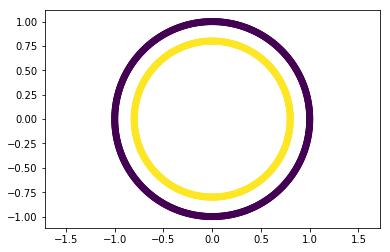

In [4]:
# cercles data
circles_data = np.loadtxt(open('circles.txt','r'))
np.random.seed(0)
indices = np.random.permutation(len(circles_data[:,-1]))
plt.scatter(circles_data[:,0],circles_data[:,1],c=circles_data[:,-1])
plt.axis('equal')

# Separate into train/valid/test with ratio 9:1:1
circles_train_x = circles_data[indices[:900],:-1]
circles_valid_x = circles_data[indices[900:1000],:-1]
circles_test_x = circles_data[indices[1000:],:-1]
circles_train_y = circles_data[indices[:900],-1]
circles_valid_y = circles_data[indices[900:1000],-1]
circles_test_y = circles_data[indices[1000:],-1]
# # Remap y classes to int 1,2
circles_train_y = (circles_train_y).astype(int)
circles_valid_y = (circles_valid_y).astype(int)
circles_test_y = (circles_test_y).astype(int)

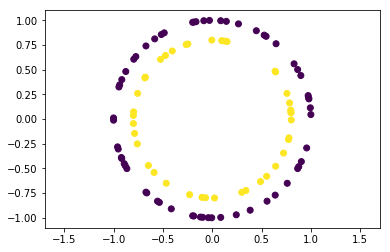

In [5]:
plt.axis('equal')
plt.scatter(circles_test_x[:,0],circles_test_x[:,1],c=circles_test_y)

In [6]:
# GRADED FUNCTION: random_mini_batches [credit to Andrew Ng]

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, feature dimension)
    Y -- "label" vector, of shape (number of examples, 1)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m,1))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k*mini_batch_size : (k+1)*mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k*mini_batch_size : (k+1)*mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [78]:
def rect(x):
    return np.maximum(0,x)

def softmax(x_v):
    return np.exp(x_v)/np.sum(np.exp(x_v),axis=0)

def cal_accuracy(npa1,npa2):
    return (np.array(npa1)==np.array(npa2)).astype(int).mean()

def cal_error_rate(npa1,npa2):
    return 1-cal_accuracy(npa1,npa2)

class NeuralNetwork:
    def __init__(self,x=None,y=None,d=None,dh=None,m=None):
        # hyperparameters
        self.lmbd11,self.lmbd12,self.lmbd21,self.lmbd22= 0.,0.,0.,0.
        self.grad_stop = 0.01
        if x is not None:
            self.x = x
            self.y = y
            self.get_n()
            self.set_params(d,dh,m)

            
    def set_params(self,d,dh,m):
        self.d = d
        self.dh = dh # number of hiden layer neurons
        self.m = m # m classes
        self.init_params()
        self.get_n()
    
    def get_n(self):
        try:
            if len(self.x.shape)>1:
                self.n = self.x.shape[1]
            else:
                self.n = 1
        except:
            pass
    
    def init_params(self):
        # Parameter initialization
        if DEBUG_FLAG:
            np.random.seed(0)
        sqrtr_nc_W1 = 1/self.d**0.5
        self.W1 = np.random.uniform(-sqrtr_nc_W1,sqrtr_nc_W1,(self.dh,self.d))
        self.b1 = np.zeros((self.dh,1))
        sqrtr_nc_W2 = 1/self.dh**0.5
        self.W2 = np.random.uniform(-sqrtr_nc_W2,sqrtr_nc_W2,(self.m,self.dh))
        self.b2 = np.zeros((self.m,1))
        self.wb2theta()
        self.gradFinitDiff = np.zeros(len(self.theta))

    def bprop(self):
        self.theta2wb()
#         import pdb
#         pdb.set_trace()
        K = self.n
        self.grad_oa = self.os - np.eye(self.m)[self.y].reshape((K,-1)).T
        self.grad_hs = self.W2.T @ self.grad_oa
        self.grad_ha = (self.ha>0).astype(int) * self.grad_hs
        self.grad_x = self.W1.T @ self.grad_ha
        # self.grad_b2 = self.grad_oa
        self.grad_b2 = np.sum(self.grad_oa,axis=1)
        # self.grad_W2 = self.grad_oa@ self.hs.reshape((-1,K)).T \
        # +self.lmbd21*np.sign(self.W2)+2*self.lmbd22*self.W2
        self.grad_W2 = self.grad_oa@ self.hs.reshape((-1,K)).T \
        +self.lmbd21*np.sign(self.W2)+2*self.lmbd22*self.W2
        # self.grad_b1 = self.grad_ha
        self.grad_b1 = np.sum(self.grad_ha,axis=1)
        # self.grad_W1 = self.grad_ha@ self.x.reshape((-1,K)).T \
        # +self.lmbd11*np.sign(self.W1)+2*self.lmbd12*self.W1
        self.grad_W1 = self.grad_ha@ self.x.reshape((-1,K)).T \
        +self.lmbd11*np.sign(self.W1)+2*self.lmbd12*self.W1
        

            
        self.serial_grad()

    def fprop(self,ischeck = False, check_theta = None):
        if ischeck == False:
            theta = self.theta
            self.theta2wb()
            W1,b1,W2,b2 = self.W1,self.b1,self.W2,self.b2
        else:
            theta = check_theta
            W1,b1,W2,b2 = self.unserial_param(check_theta)
        
        self.predict(self.x,W1,b1,W2,b2)
        #self.L = -np.log(self.os[self.y])
        self.L = -np.log(np.choose(self.y,self.os)+SYS_EPS)
        self.L_reg = self.L + self.lmbd11*np.sum(np.abs(W1)) \
        + self.lmbd12*np.sum(W1**2) \
        + self.lmbd21*np.sum(np.abs(W2)) \
        + self.lmbd22*np.sum(W2**2)
        self.L_reg = self.L_reg.mean()
        return self.L_reg
    
    def train_loop(self,train_X,train_y,iterations=100,learning_rate=10**-3,K=10,
                   DISPLAY_DETAIL = True, valid_X=None,valid_y=None, test_X=None, test_y = None):
        self.K = K
        self.alpha = learning_rate
        # Get minibatches
        batches_train = random_mini_batches(train_X,train_y.reshape((-1,1)),K)
        batches_n = len(batches_train)
        self.gradBatch = np.zeros((batches_n,len(self.theta)))    
        # Record the error and average loss in each epoch for train/valid/test data
        # self.epoch_loss[batch][0]: train
        # self.epoch_loss[batch][1]: valid
        # self.epoch_loss[batch][2]: test  
        self.epoch_loss = np.ones((iterations,3))*SYS_MAX
        self.epoch_error = np.ones((iterations,3))
        for i in tqdm_notebook(range(iterations), desc='epoch'): 
            self.epoch = i
            error_rate = np.zeros(len(batches_train))
            for ind_b,batch in enumerate(batches_train):
                batch_X = batch[0]
                batch_y = batch[1]
                gradBatch = 0
                for (ind,_) in enumerate(batch_X):
                    self.x = batch_X[ind,:]
                    self.y = batch_y[ind]
                    self.n = 1
                    self.fprop()
                    self.bprop()
                    gradBatch += self.gradBprop
                gradBatch /= K
                # Update theta
                self.theta -= gradBatch*learning_rate
                
                # Keep the gradBatch to display
                self.gradBatch[ind_b] = gradBatch
                
                error_rate[ind_b]=cal_error_rate(np.argmax(self.os,axis=0), self.y)
              
            
            self.epoch_loss[i][0] = self.L_reg
            self.epoch_error[i][0] = error_rate.mean()

                
            if valid_X is not None: 
                self.epoch_loss[i][1] = self.eval_loss(valid_X, valid_y)
                self.epoch_error[i][1] = self.eval_error(valid_X, valid_y)
            if test_X is not None:
                self.epoch_loss[i][2] = self.eval_loss(test_X, test_y)
                self.epoch_error[i][2] = self.eval_error(test_X, test_y)
                
            # Early Stop
            # Check the loss over valid
            if i>0.1*iterations and i >1:
                
                # Record the theta which gives us the min valid loss
                if self.epoch_loss[i][1]== np.min(self.epoch_loss[:,1]):
                    self.best_epoch = i
                    self.best_theta = self.theta
                
                grad_condition = np.linalg.norm(gradBatch)<self.grad_stop
                valid_condition = self.epoch_loss[i][1] == np.max(self.epoch_loss[:,1])
                if grad_condition or valid_condition:
                    if grad_condition:
                        print_blue("Converge.")
                    if valid_condition:
                        print_blue("Early Stop by valid condition.")
                    print(self.epoch_loss[i][1], self.epoch_loss[i-1][1], np.linalg.norm(gradBatch))

                    # Trunk the loss and error record to the real epoch number
                    self.epoch_loss = self.epoch_loss[:i,:]
                    self.epoch_error = self.epoch_error[:i,:]
                    break
        return
    
    def train(self,train_X,train_y,iterations=100,learning_rate=10**-3,K=10,
                   DISPLAY_DETAIL = True, valid_X=None, valid_y=None, test_X=None, test_y = None):
        self.K = K
        self.alpha = learning_rate
        # Get minibatches
        batches_train = random_mini_batches(train_X,train_y.reshape((-1,1)),K)
        batches_n = len(batches_train)
        # Record the gradient of each batch in last epoch
        self.gradBatch = np.zeros((batches_n,len(self.theta)))
        
        # Record the error and average loss in each epoch for train/valid/test data
        # self.epoch_loss[batch][0]: train
        # self.epoch_loss[batch][1]: valid
        # self.epoch_loss[batch][2]: test  
        self.epoch_loss = np.ones((iterations,3))*SYS_MAX
        self.epoch_error = np.ones((iterations,3))
        
        for i in tqdm_notebook(range(iterations), desc='epoch'): 
            self.epoch = i
            error_rate = np.zeros(len(batches_train))
            for ind_b,batch in enumerate(batches_train):
                batch_X = batch[0]
                batch_y = batch[1]
                gradBatch = 0
  
                # Calcul batch gradient
                self.x = batch_X.T
                self.y = batch_y.T
                self.n = self.get_n()
                self.fprop()
                self.bprop()
                gradBatch = self.gradBprop
                gradBatch /= K
                # Update theta
                self.theta -= gradBatch*learning_rate
                
                # Keep the gradBatch to display
                self.gradBatch[ind_b] = gradBatch
                
                error_rate[ind_b]=cal_error_rate(np.argmax(self.os,axis=0), self.y)
              
            
            self.epoch_loss[i][0] = self.L_reg
            self.epoch_error[i][0] = error_rate.mean()

                
            if valid_X is not None: 
                self.epoch_loss[i][1] = self.eval_loss(valid_X, valid_y)
                self.epoch_error[i][1] = self.eval_error(valid_X, valid_y)
            if test_X is not None:
                self.epoch_loss[i][2] = self.eval_loss(test_X, test_y)
                self.epoch_error[i][2] = self.eval_error(test_X, test_y)
            
            if DISPLAY_DETAIL:
                print("#Epoch:{}\t Training Loss:{:.4f}\t Valid Loss:{:.4f} \t Grad_len:{:.4f}".format(
                    i,self.L_reg, self.epoch_loss[i][1],np.linalg.norm(gradBatch)))
            
            
            # Early Stop
            # Check the loss over valid
            if i>0.1*iterations and i >1:
                
                # Record the theta which gives us the min valid loss
                if self.epoch_loss[i][1]== np.min(self.epoch_loss[:,1]):
                    self.best_epoch = i
                    self.best_theta = self.theta
                
                grad_condition = np.linalg.norm(gradBatch)<self.grad_stop
                valid_condition = self.epoch_loss[i][1] == np.max(self.epoch_loss[:,1])
                if grad_condition or valid_condition:
                    if grad_condition:
                        print_blue("Converge.")
                    if valid_condition:
                        print_blue("Early Stop by valid condition.")
                    print(self.epoch_loss[i][1], self.epoch_loss[i-1][1], np.linalg.norm(gradBatch))

                    # Trunk the loss and error record to the real epoch number
                    self.epoch_loss = self.epoch_loss[:i,:]
                    self.epoch_error = self.epoch_error[:i,:]
                    break
                
        return
    
    def predict(self, test_x,W1,b1,W2,b2):
        self.x = test_x
        self.get_n()
        if DEBUG_FLAG:
            print(W1.shape)
            print(self.x.shape)
        self.ha = (W1@self.x).reshape((-1,self.n))+b1
        self.hs = rect(self.ha)
        self.oa = (W2@self.hs).reshape((-1,self.n))+b2
        self.os = softmax(self.oa)
        return np.argmax(self.os,axis=0)
    
    
    def eval_loss_loop(self, data_X, data_y):
        loss = 0
        data_size = data_X.shape[0]
        for i in range(data_size):
            self.x = data_X[i,:]
            self.y = data_y[i]
            loss += self.fprop()
        return loss/data_size
    
    def eval_loss(self, data_X, data_y):
        loss = 0
        data_size = data_X.shape[0]

        model_temp = NeuralNetwork(data_X.T,data_y.reshape((-1,1)).T,self.d,self.dh,self.m)
        model_temp.theta = self.theta
        
        loss = model_temp.fprop()
        
        return np.mean(loss)
    
    def eval_error(self, data_X, data_y):
        predict_list = []
        self.n = self.get_n()
        self.theta2wb()
        predict_list = self.predict(data_X.T,self.W1,self.b1,self.W2,self.b2)
        return cal_error_rate(predict_list,data_y)
        
    def serial_param(self,W1,b1,W2,b2):
        return np.concatenate([np.ravel(W1),
                                     np.ravel(b1),
                                     np.ravel(W2),
                                     np.ravel(b2)])
        
    def unserial_param(self,theta):
        dh = self.dh
        d = self.d
        W1 = theta[0:dh*d].reshape((dh,d))
        b1 = theta[dh*d:dh*d+dh].reshape(-1,1)
        W2 = theta[dh*d+dh:dh*d+dh+m*dh].reshape((m,dh))
        b2 = theta[-m:].reshape(-1,1)
        return W1,b1,W2,b2
    
    def wb2theta(self):
        self.theta = self.serial_param(self.W1,self.b1,self.W2,self.b2)
        
    
    def theta2wb(self):
        self.W1,self.b1,self.W2,self.b2 = self.unserial_param(self.theta)
        
    def serial_grad(self):
        self.gradBprop = np.concatenate([np.ravel(self.grad_W1),
                             np.ravel(self.grad_b1),
                             np.ravel(self.grad_W2),
                             np.ravel(self.grad_b2)])

    def cal_finit_difference(self):
        epsilon = 10**-5
        for ind,t in enumerate(self.theta):
            thetaPlus = np.copy(self.theta)
            thetaPlus[ind] += epsilon
            self.gradFinitDiff[ind] = ((self.fprop(True,thetaPlus)-self.fprop())/epsilon)

    def gradient_check(self):
        ratio = (self.gradFinitDiff+SYS_EPS)/(self.gradBprop+SYS_EPS)
        if np.any(ratio>1.01) or np.any(ratio<0.99):
            print_red("Gradient check failed.")
            print("ratio=",ratio)
        else:
            print_green("Gradient check succeeded.")
    
    def show_two_grads(self):
        data = np.vstack((self.gradBprop, self.gradFinitDiff))
        df = pd.DataFrame(data)
        df = pd.DataFrame({'Grad':["Grad Backprop","Grad Finit Diff"]}).join(df)
        display(df.round(4))
        #print(df.round(4).to_latex())
        return

### 3.1

In [8]:
d = 2
dh = 2
m = 2
model = NeuralNetwork(circles_train_x[0,:],circles_train_y[0],d,dh,m)
model.fprop()
model.bprop()
model.cal_finit_difference()
model.gradient_check()

Gradient check succeeded.


### 3.2

In [9]:
print(circles_train_x[0,:])
print(circles_train_y[0])
model.show_two_grads()

[-0.71383959 -0.36115515]
1


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,0.0,0.0,-0.0722,-0.0365,0.0,0.1012,0.0,0.2398,0.0,-0.2398,0.5222,-0.5222
1,Grad Finit Diff,0.0,0.0,-0.0722,-0.0365,0.0,0.1012,0.0,0.2398,0.0,-0.2398,0.5222,-0.5222


### 3.3 & 3.4

In [10]:
# mini batch size
K = 10
data_batch_X = circles_train_x[:K,:]
data_batch_y = circles_train_y[:K]
print(data_batch_X,data_batch_y)
for (ind,_) in enumerate(data_batch_X):
    print("#record:",ind)
    model = NeuralNetwork(data_batch_X[ind,:],data_batch_y[ind],d,dh,m)
    model.set_params(d,dh,m)
    model.fprop()
    model.bprop()
    model.cal_finit_difference()
    model.gradient_check()
    model.show_two_grads()

[[-0.71383959 -0.36115515]
 [ 0.31986144  0.94746433]
 [ 0.41541501  0.909632  ]
 [ 0.99348174 -0.11399141]
 [-0.78496073 -0.15439123]
 [ 0.79666134 -0.07301169]
 [-0.34142368 -0.9399095 ]
 [-0.06279052 -0.99802673]
 [ 0.76496954  0.23414013]
 [ 0.94184436  0.33604939]] [1 0 0 0 1 1 0 0 1 0]
#record: 0
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,0.1552,0.0785,0.0,0.0,-0.2175,0.0,0.0858,0.0,-0.0858,0.0,0.4797,-0.4797
1,Grad Finit Diff,0.1552,0.0785,0.0,0.0,-0.2175,0.0,0.0858,0.0,-0.0858,0.0,0.4797,-0.4797


#record: 1
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,-0.1257,-0.3723,0.0,-0.0,-0.393,0.0,-0.0544,-0.0,0.0544,0.0,-0.4765,0.4765
1,Grad Finit Diff,-0.1257,-0.3723,0.0,0.0,-0.393,0.0,-0.0544,0.0,0.0544,0.0,-0.4765,0.4765


#record: 2
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.5
1,Grad Finit Diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.5


#record: 3
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,-0.0547,0.0063,0.0,0.0,-0.055,0.0,-0.2116,0.0,0.2116,0.0,-0.4878,0.4878
1,Grad Finit Diff,-0.0547,0.0063,0.0,0.0,-0.055,0.0,-0.2116,0.0,0.2116,0.0,-0.4878,0.4878


#record: 4
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,0.0599,0.0118,0.0,0.0,-0.0762,0.0,0.2092,0.0,-0.2092,0.0,0.4829,-0.4829
1,Grad Finit Diff,0.0599,0.0118,0.0,0.0,-0.0762,0.0,0.2092,0.0,-0.2092,0.0,0.4829,-0.4829


#record: 5
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,-0.0,0.0,0.2872,-0.0263,0.0,0.3605,0.0,0.034,-0.0,-0.034,0.5117,-0.5117
1,Grad Finit Diff,0.0,0.0,0.2872,-0.0263,0.0,0.3605,0.0,0.034,0.0,-0.034,0.5117,-0.5117


#record: 6
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.5,0.5
1,Grad Finit Diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.5


#record: 7
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.5
1,Grad Finit Diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.5


#record: 8
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,-0.2657,-0.0813,-0.296,-0.0906,-0.3473,-0.3869,0.0991,0.0375,-0.0991,-0.0375,0.436,-0.436
1,Grad Finit Diff,-0.2657,-0.0813,-0.296,-0.0906,-0.3473,-0.3869,0.0991,0.0375,-0.0991,-0.0375,0.436,-0.436


#record: 9
Gradient check succeeded.


,Grad,0,1,2,3,4,5,6,7,8,9,10,11
0,Grad Backprop,0.4729,0.1687,-0.1118,-0.0399,0.5021,-0.1187,-0.1137,-0.4115,0.1137,0.4115,-0.508,0.508
1,Grad Finit Diff,0.4729,0.1687,-0.1118,-0.0399,0.5021,-0.1187,-0.1137,-0.4115,0.1137,0.4115,-0.508,0.508


### 3.5

In [11]:
d = 2
dh = 4
m = 2
model_3_5 = NeuralNetwork()
model_3_5.set_params(d,dh,m)
model_3_5.train_loop(circles_train_x, circles_train_y, 100, 10**-2, 10, True,
                     circles_valid_x, circles_valid_y)

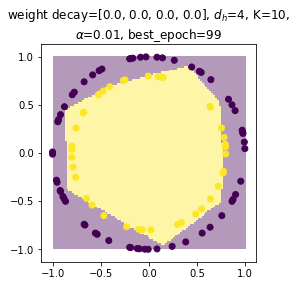

In [12]:
def draw_boundary(model):
    # Draw decision boundary
    range_x1 = np.linspace(-1,1,100)
    range_x2 = range_x1 
    xx1,xx2 = np.meshgrid(range_x1, range_x2)
    data = np.c_[xx1.ravel(),xx2.ravel()]

    plot_list = []
    for d in data:
        plot_list.append(model.predict(d,model.W1,model.b1,model.W2,model.b2))
    Z = np.array(plot_list).reshape(xx1.shape)

    plt.imshow(Z, extent=(xx1.min(), xx1.max(), xx2.min(), xx2.max()), alpha=.4, origin='lower')
    plt.scatter(circles_test_x[:,0],circles_test_x[:,1],c=circles_test_y)
    plt.title('weight decay={}, $d_h$={}, K={},\n$\\alpha$={}, best_epoch={}'.format(
        [model.lmbd11,model.lmbd12,model.lmbd21,model.lmbd22]
        ,model.dh
        ,model.K
        ,model.alpha
        ,model.best_epoch))
    plt.show()
    
draw_boundary(model_3_5)

### 3.6

In [13]:
d = 2
dh = 2000
m = 2
model_3_6 = NeuralNetwork()
model_3_6.lmbd11,model_3_6.lmbd12,model_3_6.lmbd21,model_3_6.lmbd22= 0.1,0.1,0.1,0.1
model_3_6.set_params(d,dh,m)
model_3_6.train(circles_train_x, circles_train_y, 500, 10**-2, 200, False,
                circles_valid_x, circles_valid_y, circles_test_x, circles_test_y)

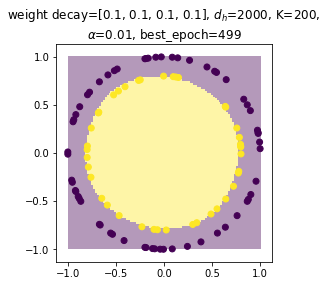

In [14]:
draw_boundary(model_3_6)

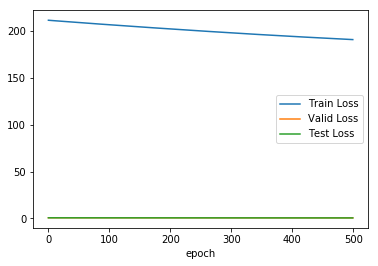

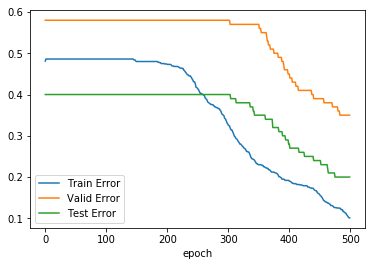

In [15]:
labels = ['Train Loss','Valid Loss','Test Loss']
for d, label in zip(model_3_6.epoch_loss.T, labels):
    plt.plot(d, label=label)
plt.xlabel("epoch")
plt.legend()
plt.show()
labels = ['Train Error','Valid Error','Test Error']
for d, label in zip(model_3_6.epoch_error.T, labels):
    plt.plot(d, label=label)
plt.xlabel("epoch")
plt.legend()
plt.show()

### 3.7

In [79]:
d = 2
dh = 4
m = 2
max_iteratiosns = 1
learning_rate = 10**-2

X = circles_train_x
y = circles_train_y

grads_table = {"K1":{},"K10":{}}

for K in [1,10]:
    model_loop = NeuralNetwork()
    model_loop.set_params(d,dh,m)
    model_loop.train_loop(X, y, max_iteratiosns, learning_rate , K, 
                          False, circles_valid_x, circles_valid_y)
    grads_table["K{}".format(K)]["loop"] = model_loop.gradBatch
    model_matrix = NeuralNetwork()
    model_matrix.set_params(d,dh,m)
    model_matrix.train(X, y, max_iteratiosns, learning_rate, K, 
                          False, circles_valid_x, circles_valid_y)
    grads_table["K{}".format(K)]["matrix"] = model_matrix.gradBatch



=====



=====


In [74]:
df_K1_loop = pd.DataFrame(grads_table["K1"]["loop"])
df_K1_matrix = pd.DataFrame(grads_table["K1"]["matrix"])
df_K10_loop = pd.DataFrame(grads_table["K10"]["loop"])
df_K10_matrix = pd.DataFrame(grads_table["K10"]["matrix"])

#### K=1

##### a) Gradients of Loop method

In [75]:
display(df_K1_loop)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206886,-0.222849,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.101841,0.000000,0.000000,0.000000,-0.101841,0.533898,-0.533898
1,0.081481,0.010293,0.041102,0.005192,0.171622,0.021681,0.000000,0.000000,-0.102661,-0.051786,...,0.125234,0.040828,0.066685,0.000000,-0.125234,-0.040828,-0.066685,0.000000,0.463143,-0.463143
2,-0.108629,0.064663,-0.054580,0.032489,-0.226893,0.135060,0.000000,0.000000,0.126418,0.063518,...,-0.118462,-0.139051,-0.195610,0.000000,0.118462,0.139051,0.195610,0.000000,-0.563949,0.563949
3,0.073078,0.043500,0.000000,0.000000,0.152979,0.091062,0.000000,0.000000,-0.106306,0.000000,...,0.133215,0.000000,0.012959,0.000000,-0.133215,0.000000,-0.012959,0.000000,0.479296,-0.479296
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.280382,0.171268,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.109036,0.000000,0.000000,0.000000,0.109036,-0.462820,0.462820
5,0.015940,0.089079,0.000000,0.000000,0.000000,0.000000,-0.050568,-0.282591,-0.113117,0.000000,...,0.077888,0.000000,0.000000,0.042099,-0.077888,0.000000,0.000000,-0.042099,0.503951,-0.503951
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.287676,0.063441,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.065572,0.000000,0.000000,0.000000,-0.065572,0.517744,-0.517744
7,0.081918,-0.002809,0.039814,-0.001365,0.168375,-0.005773,0.000000,0.000000,-0.102457,-0.049797,...,0.116643,0.054258,0.084464,0.000000,-0.116643,-0.054258,-0.084464,0.000000,0.453314,-0.453314
8,-0.075724,-0.093694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120468,0.000000,...,-0.165991,0.000000,0.000000,0.000000,0.165991,0.000000,0.000000,0.000000,-0.527557,0.527557
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.145800,0.300869,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.095714,0.000000,0.000000,0.000000,0.095714,-0.470947,0.470947


##### b) Gradients of Matrix calculus method

In [76]:
display(df_K1_matrix)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.206886,-0.222849,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.101841,0.000000,0.000000,0.000000,-0.101841,0.533898,-0.533898
1,0.081481,0.010293,0.041102,0.005192,0.171622,0.021681,0.000000,-0.000000,-0.102661,-0.051786,...,0.125234,0.040828,0.066685,0.000000,-0.125234,-0.040828,-0.066685,-0.000000,0.463143,-0.463143
2,-0.108629,0.064663,-0.054580,0.032489,-0.226893,0.135060,0.000000,-0.000000,0.126418,0.063518,...,-0.118462,-0.139051,-0.195610,0.000000,0.118462,0.139051,0.195610,0.000000,-0.563949,0.563949
3,0.073078,0.043500,0.000000,0.000000,0.152979,0.091062,0.000000,-0.000000,-0.106306,0.000000,...,0.133215,0.000000,0.012959,0.000000,-0.133215,0.000000,-0.012959,-0.000000,0.479296,-0.479296
4,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.280382,0.171268,0.000000,0.000000,...,-0.000000,0.000000,-0.000000,-0.109036,0.000000,0.000000,0.000000,0.109036,-0.462820,0.462820
5,0.015940,0.089079,0.000000,0.000000,0.000000,0.000000,-0.050568,-0.282591,-0.113117,0.000000,...,0.077888,0.000000,0.000000,0.042099,-0.077888,0.000000,0.000000,-0.042099,0.503951,-0.503951
6,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.287676,0.063441,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.065572,0.000000,0.000000,0.000000,-0.065572,0.517744,-0.517744
7,0.081918,-0.002809,0.039814,-0.001365,0.168375,-0.005773,0.000000,0.000000,-0.102457,-0.049797,...,0.116643,0.054258,0.084464,0.000000,-0.116643,-0.054258,-0.084464,-0.000000,0.453314,-0.453314
8,-0.075724,-0.093694,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.120468,0.000000,...,-0.165991,0.000000,-0.000000,0.000000,0.165991,0.000000,0.000000,0.000000,-0.527557,0.527557
9,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.145800,0.300869,0.000000,0.000000,...,-0.000000,0.000000,-0.000000,-0.095714,0.000000,0.000000,0.000000,0.095714,-0.470947,0.470947


##### c) Check equality of the gradients of both methods

In [77]:
ratio = (np.abs(grads_table["K1"]["loop"])+10**-5) / (np.abs(grads_table["K1"]["matrix"])+10**-5)
np.all(ratio<1.01) and  np.all(ratio >0.99)

True

#### K=10

##### a) Gradients of Loop method

In [38]:
display(df_K10_loop)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.016835,0.018256,-0.016015,-0.012919,-0.036979,0.021847,0.019089,-0.002006,-0.019089,0.002006,0.092256,-0.092256
1,0.019412,-0.065917,-0.043314,-0.005285,0.002330,0.046421,-0.006362,0.010781,0.006362,-0.010781,0.097419,-0.097419
2,-0.032935,0.002744,0.039725,-0.012288,0.023572,-0.068673,-0.024930,-0.019042,0.024930,0.019042,-0.005925,0.005925
3,-0.020517,0.001640,0.012012,-0.025492,0.022903,-0.046093,-0.015524,-0.017605,0.015524,0.017605,0.094375,-0.094375
4,-0.012340,-0.000831,0.031707,-0.026064,0.020524,-0.043120,-0.009902,-0.024279,0.009902,0.024279,-0.097790,0.097790
5,-0.022550,0.018186,0.033770,-0.032334,0.003546,-0.045593,-0.011761,-0.028416,0.011761,0.028416,-0.005413,0.005413
6,0.020309,-0.036627,-0.049925,0.020776,-0.019375,0.048524,0.003880,0.027333,-0.003880,-0.027333,0.005812,-0.005812
7,0.006546,0.031355,0.029066,0.020835,-0.018571,0.024639,0.015329,0.002051,-0.015329,-0.002051,0.199780,-0.199780
8,0.035636,-0.008278,-0.042712,0.005328,-0.057572,0.068939,0.025123,0.016441,-0.025123,-0.016441,0.097239,-0.097239
9,0.029586,0.030139,-0.010201,0.009689,-0.076043,0.020239,0.032975,0.008483,-0.032975,-0.008483,0.188147,-0.188147


##### b) Gradients of Matrix calculus method

In [39]:
display(df_K10_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.016835,0.018256,-0.016015,-0.012919,-0.036979,0.021847,0.019089,-0.002006,-0.019089,0.002006,0.092256,-0.092256
1,0.019412,-0.065917,-0.043314,-0.005285,0.002330,0.046421,-0.006362,0.010781,0.006362,-0.010781,0.097419,-0.097419
2,-0.032935,0.002744,0.039725,-0.012288,0.023572,-0.068673,-0.024930,-0.019042,0.024930,0.019042,-0.005925,0.005925
3,-0.020517,0.001640,0.012012,-0.025492,0.022903,-0.046093,-0.015524,-0.017605,0.015524,0.017605,0.094375,-0.094375
4,-0.012340,-0.000831,0.031707,-0.026064,0.020524,-0.043120,-0.009902,-0.024279,0.009902,0.024279,-0.097790,0.097790
5,-0.022550,0.018186,0.033770,-0.032334,0.003546,-0.045593,-0.011761,-0.028416,0.011761,0.028416,-0.005413,0.005413
6,0.020309,-0.036627,-0.049925,0.020776,-0.019375,0.048524,0.003880,0.027333,-0.003880,-0.027333,0.005812,-0.005812
7,0.006546,0.031355,0.029066,0.020835,-0.018571,0.024639,0.015329,0.002051,-0.015329,-0.002051,0.199780,-0.199780
8,0.035636,-0.008278,-0.042712,0.005328,-0.057572,0.068939,0.025123,0.016441,-0.025123,-0.016441,0.097239,-0.097239
9,0.029586,0.030139,-0.010201,0.009689,-0.076043,0.020239,0.032975,0.008483,-0.032975,-0.008483,0.188147,-0.188147


##### c) Check equality of the gradients of both methods

In [40]:
ratio = (grads_table["K10"]["loop"]+10**-5) / (grads_table["K10"]["matrix"]+10**-5)
np.all(ratio<1.01) and  np.all(ratio >0.99)

True

### 3.8

In [24]:
# fashion MNIST
import utils.mnist_reader as mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [25]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [26]:
n = len(y_train)
indices = np.random.permutation(n)
SP_PT = int(n*0.9)
X_valid = X_train[SP_PT:,:]
y_valid = y_train[SP_PT:]
X_train = X_train[:SP_PT,:]
y_train = y_train[:SP_PT]

In [27]:
print(X_valid.shape)
print(y_valid.shape)
print(X_train.shape)
print(y_train.shape)

(6000, 784)
(6000,)
(54000, 784)
(54000,)


In [28]:
d = 784
dh = 2
m = 10
max_iteratiosns = 1
learning_rate = 10**-2

X = X_train
y = y_train

K=100

In [29]:
%%time
model_loop = NeuralNetwork()
model_loop.set_params(d,dh,m)
model_loop.train_loop(X, y, max_iteratiosns, learning_rate , K, 
                      False, X_valid, y_valid)


CPU times: user 15.7 s, sys: 167 ms, total: 15.9 s
Wall time: 16 s


In [30]:
%%time
model_matrix = NeuralNetwork()
model_matrix.set_params(d,dh,m)
model_matrix.train(X, y, max_iteratiosns, learning_rate, K, 
                      False, X_valid, y_valid)


CPU times: user 1.15 s, sys: 73.4 ms, total: 1.22 s
Wall time: 654 ms


 #### Comparison
 - One epoch with Loop method takes around 13.7s
 - One epoch with Matrix Calculus method takes around 473ms

### 3.9 & 3.10

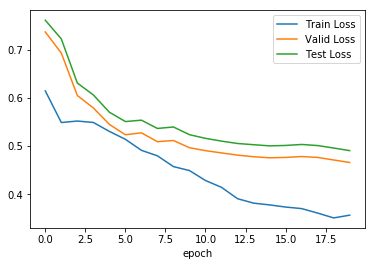

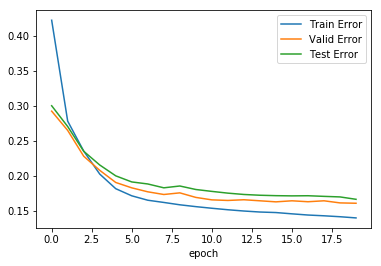

In [31]:
d = 784
dh = 64
m = 10
max_iteratiosns = 20
learning_rate = 10**-3

X = X_train
y = y_train

K=64

model_3_10 = NeuralNetwork()
model_3_10.set_params(d,dh,m)
model_3_10.train(X, y, max_iteratiosns, learning_rate, K, 
                      False, X_valid, y_valid, X_test, y_test)

log_data = np.c_[model_3_6.epoch_loss,model_3_6.epoch_error]
json.dump(log_data.tolist(),open("./log.json","w"))

labels = ['Train Loss','Valid Loss','Test Loss']
for d, label in zip(model_3_10.epoch_loss.T, labels):
    plt.plot(d, label=label)
plt.xlabel("epoch")
plt.legend()
plt.show()
labels = ['Train Error','Valid Error','Test Error']
for d, label in zip(model_3_10.epoch_error.T, labels):
    plt.plot(d, label=label)
plt.xlabel("epoch")
plt.legend()
plt.show()